<div class="alert alert-success">
<h3> Will be transated...</h3>

</div>

## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [12]:
# импортируем основные библиотеки
import pandas as pd
import numpy as np
from IPython.display import display

# импортируем pymystem3 и счетчик
from pymystem3 import Mystem
m = Mystem()
from collections import Counter

# читаем и смотрим файл с данными
borrowers = pd.read_csv('/datasets/data.csv')
display(borrowers)
display(borrowers['children'].value_counts()) # Применяем к разным столбцам для первичного анализа

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

### Вывод

Имеются артефакты:
1. Возраст клиента в годах 0.
2. Трудовой стаж - отрицательные значения (кроме безработных и пенсионеров), при этом положительные величины явно не соответствуют стажу в днях, скорее это стаж в часах. Отрицательные значения возможно появились после объединения данных с информацией о занятости, где отрицательные значения соответствуют статусу "не работающий".
3. Количество детей -1. Вероятно это значение соответствует 1 ребенку в семье, знак минус появился ошибочно.
4. Количество детей 20 в 76 случаях. Это выбивается из статистического распределения количества детей. Возможно эти значения появились в результате ошибочного ввода в другое поле формы, либо это результат некорректного объединения данных.
5. В одной строке признак пола: XNA.


### Шаг 2. Предобработка данных

### Обработка пропусков

In [13]:
# Смотрим на пропуски
display(borrowers.isna().sum())
display(borrowers[borrowers['days_employed'].isnull()].head())
display(borrowers[borrowers['total_income'].isnull()].head())
display(borrowers[(borrowers['days_employed'].isnull()) & (borrowers['total_income'].isnull())])
display(borrowers.info())
# Дополнительно убедились, что NaN встречаются парами в строках
display(borrowers[borrowers.isnull().T.any().T].info()) 

# Заполняем пропуски в столбце 'total_income' медианой по группам столбца 'income_type'
medintypes = borrowers.groupby('income_type', sort=False)['total_income'].median()
utypes = borrowers['income_type'].unique()
try: 
    for i in range(len(utypes)):
        borrowers.loc[borrowers['income_type'] == utypes[i], 'total_income'] = borrowers.loc[borrowers['income_type'] == utypes[i], 'total_income'].fillna(value=medintypes[i])
except: 
    print('Ошибка при заполнении пропусков')
# Убедились, что змена прошла успешно
display(borrowers[(borrowers['days_employed'].isnull())])

# Меняем нули в столбце dob_years на средний возраст по всем данным
avr_dob_years = borrowers[borrowers['dob_years'] != 0]['dob_years'].mean()
display(avr_dob_years)
borrowers.loc[borrowers['dob_years'] == 0, 'dob_years'] = avr_dob_years

# Корректируем столбец 'days_employed'
## Меняем значения в часах на значения в днях
borrowers.loc[borrowers['days_employed'] > 0, 'days_employed'] = borrowers.loc[borrowers['days_employed'] > 0, 'days_employed'] / 24
## Меняем отрицательные значения в днях на положительные значения в днях
borrowers.loc[borrowers['days_employed'] < 0, 'days_employed'] = borrowers.loc[borrowers['days_employed'] < 0, 'days_employed'] * -1

# Заполняем пропуски в столбце 'days_employed' исходя из возраста и предположения, что человек начал работать в 20 лет
borrowers['days_employed'] = borrowers['days_employed'].fillna(value=borrowers['dob_years']-20)
# Убедились, что змена прошла успешно
display(borrowers.info())

# Корректируем столбец 'children', меняем отрицательные значения на положительные
borrowers.loc[borrowers['children'] < 0, 'children'] = borrowers.loc[borrowers['children'] < 0, 'children'] * -1
# Убедились, что змена прошла успешно
display(borrowers['children'].value_counts())

# Проверяем столбцы с тектовой информацией
display(borrowers['family_status'].value_counts())
display(borrowers['education'].value_counts())
display(borrowers['income_type'].value_counts())
display(borrowers['purpose'].value_counts())
## Переводим столбцы с наличием текста со смешанным регистром в нижний регистр
borrowers['family_status'] = borrowers['family_status'].str.lower()
borrowers['education'] = borrowers['education'].str.lower()
## Проверяем корректность замены
display(borrowers['family_status'].value_counts())
display(borrowers['education'].value_counts())

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 12 to 21510
Data columns (total 12 columns):
children            2174 non-null int64
days_employed       0 non-null float64
dob_years           2174 non-null int64
education           2174 non-null object
education_id        2174 non-null int64
family_status       2174 non-null object
family_status_id    2174 non-null int64
gender              2174 non-null object
income_type         2174 non-null object
debt                2174 non-null int64
total_income        0 non-null float64
purpose             2174 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 220.8+ KB


None

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,118514.486412,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,150447.935283,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,118514.486412,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,150447.935283,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,118514.486412,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,172357.950966,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,142594.396847,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,172357.950966,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,142594.396847,строительство жилой недвижимости


43.497479462285284

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null float64
dob_years           21525 non-null float64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 2.0+ MB


None

0     14149
1      4865
2      2055
3       330
20       76
4        41
5         9
Name: children, dtype: int64

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
операции с жильем                         653
покупка жилья для сдачи                   653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
покупка своего жилья                      620
строительство недвижимости                620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

женат / замужем          12380
гражданский брак          4177
не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

### Вывод

Обнаружили NaN в столбцах days_employed и total_income, посчитали количество пропусков в столбцах: 2174
Определили, что пропуски встречаются в строках одновременно для значений days_employed (дни занятости) и total_income (общий доход). Возможная причина - отсутствие данных об источнике дохода некоторых клиентов (клиент не предоставил).

### Замена типа данных

In [15]:
# Меняем вещественный тип данных столбца 'days_employed' к целочисленному типу и выполняем проверку
borrowers[['days_employed', 'total_income']] = borrowers[['days_employed', 'total_income']].astype('int')
display(borrowers['days_employed'])

# Меняем вещественный тип данных столбца total_income' к целочисленному типу и выполняем проверку
#borrowers['total_income'] = borrowers['total_income'].astype('int') # Удалили
display(borrowers['total_income'])

0         8437
1         4024
2         5623
3         4124
4        14177
         ...  
21520     4529
21521    14330
21522     2113
21523     3112
21524     1984
Name: days_employed, Length: 21525, dtype: int64

0        253875
1        112080
2        145885
3        267628
4        158616
          ...  
21520    224791
21521    155999
21522     89672
21523    244093
21524     82047
Name: total_income, Length: 21525, dtype: int64

### Вывод

Применили метод .astype() к столбцам 'days_employed' и 'total_income'. Этот метод используется для преобразования числовых данных одного типа в числовые данные другого типа.

### Обработка дубликатов

In [4]:
# Определяем количество дубликатов в таблице стандартным методом
display(borrowers.duplicated().sum())

# Удаляем дубликаты стандартным методом и проверяем результат
borrowers = borrowers.drop_duplicates().reset_index(drop=True)
display(borrowers.duplicated().sum())

# Считаем средний процент задолженностей по всем данным
display((borrowers['debt'].sum() / borrowers['debt'].count() * 100).round(2))

71

0

8.12

### Вывод

В данных обнаружен 71 дубликат. Возможная причина - человеческий фактор, например при формировании общей таблицы путем копирования. Удалили дубликаты методом .drop_duplicates(). 

### Лемматизация

In [5]:
# Создаем новый столбец с леммати и смотрим возможные значения
borrowers['lemmas'] = borrowers['purpose'].apply(m.lemmatize)
borrowers['lemmas'] = borrowers['lemmas'].apply(' '.join)
display(borrowers['lemmas'].value_counts())

# Убеждаемся, что ничего не утеряно
display(borrowers['lemmas'].value_counts().sum())

автомобиль \n                                    972
свадьба \n                                       791
на   проведение   свадьба \n                     768
сыграть   свадьба \n                             765
операция   с   недвижимость \n                   675
покупка   коммерческий   недвижимость \n         661
операция   с   жилье \n                          652
покупка   жилье   для   сдача \n                 651
операция   с   коммерческий   недвижимость \n    650
жилье \n                                         646
покупка   жилье \n                               646
покупка   жилье   для   семья \n                 638
строительство   собственный   недвижимость \n    635
недвижимость \n                                  633
операция   со   свой   недвижимость \n           627
строительство   жилой   недвижимость \n          624
покупка   недвижимость \n                        621
покупка   свой   жилье \n                        620
строительство   недвижимость \n               

21454

### Вывод

Создали новый столбец 'lemmas' и добавили в него обработанные с помощью библиотеки pymystem3 данные столбца 'purpose'.
Лемматизировав цели получиения кредита выявлено 5 фактических категорий: автомобиль, жилье/собственная недвижимость, коммерческая недвижимость, образование и свадьба.

### Категоризация данных

In [6]:
# Создаем функцию котегоризации цели кредита по лемматизированному столбцу
def purpose_group(row):
    for word in row.split(' '):
        if word == 'автомобиль':
            return 0
        if word == 'недвижимость':
            for word2 in row.split(' '):
                if word2 == 'коммерческий':
                    return 2
            return 1
        if word == 'жилье':
            return 1
        if word == 'образование':
            return 3
        if word == 'свадьба':
            return 4

# Создаем новый столбец с систематизированными целями кредита
borrowers['purpose_id'] = borrowers['lemmas'].apply(purpose_group)

# Создаем словарь для признака цели кредита
row_values_purp = [[0, 'автомобиль'], [1, 'жилье'], [2, 'коммерческая недвижимость'], [3, 'образование'], [4, 'свадьба']] 
columns_purp = ['purpose_id', 'purpose']
purpose_dict = pd.DataFrame(data=row_values_purp, columns=columns_purp)
display(purpose_dict)

# Создаем словарь для признака образования
education_dict = borrowers[['education_id', 'education']].drop_duplicates().reset_index(drop=True)
display(education_dict)

# Создаем словарь для признака семейного статуса
family_status_dict = borrowers[['family_status_id', 'family_status']].drop_duplicates().reset_index(drop=True)
display(family_status_dict)

# Создаем функцию группировки доходов заемщиков
def total_income_group(income):
        if income < 50000:
                return 0
        if income <= 100000:
                return 1
        if income <= 150000:
                return 2
        if income <= 250000:
                return 3
        return 4

# Создаем новый столбец с группой дхода
borrowers['total_income_id'] = borrowers['total_income'].apply(total_income_group)

# Создаем словарь для признака цели дохода
row_values_inc = [[0, '< 50'], [1, '50-100'], [2, '100-150'], [3, '150-250'], [4, '> 250']] 
columns_inc = ['total_income_id', 'total_income']
total_income_dict = pd.DataFrame(data=row_values_inc, columns=columns_inc)
display(total_income_dict)

# Исследования по разным срезам данных
## Срез цель - доход
pivot1_sum = borrowers.pivot_table(index=['purpose_id'], columns='total_income_id', values='debt', aggfunc='sum')
pivot1_count = borrowers.pivot_table(index=['purpose_id'], columns='total_income_id', values='debt', aggfunc='count')
rel1 = (pivot1_sum/pivot1_count*100).round(2)
display(rel1.head(30))
# display(rel1.sum())
# display(rel1.T.sum())

## Срез доход - образование
pivot2_sum = borrowers.pivot_table(index=['total_income_id'], columns='education_id', values='debt', aggfunc='sum')
pivot2_count = borrowers.pivot_table(index=['total_income_id'], columns='education_id', values='debt', aggfunc='count')
rel2 = (pivot2_sum/pivot2_count*100).round(2)
display(rel2.head(30))
# display(rel2.sum())
# display(rel2.T.sum())

## Срез количество детей - образование
pivot3_sum = borrowers.pivot_table(index=['children'], columns='education_id', values='debt', aggfunc='sum')
pivot3_count = borrowers.pivot_table(index=['children'], columns='education_id', values='debt', aggfunc='count')
rel3 = (pivot3_sum/pivot3_count*100).round(2)
display(rel3.head(30))
# display(rel3.sum())
# display(rel3.T.sum())

,purpose_id,purpose
0,0,автомобиль
1,1,жилье
2,2,коммерческая недвижимость
3,3,образование
4,4,свадьба


,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,не женат / не замужем


,total_income_id,total_income
0,0,< 50
1,1,50-100
2,2,100-150
3,3,150-250
4,4,> 250


total_income_id,0,1,2,3,4
purpose_id,,,,,
0,13.51,7.85,10.26,9.37,8.51
1,4.49,7.30,7.59,7.47,5.70
2,4.35,6.11,6.83,8.57,9.58
3,2.47,10.29,9.60,8.98,8.27
4,7.89,9.11,9.69,6.72,5.12


education_id,0,1,2,3,4
total_income_id,,,,,
0,3.23,6.81,0.00,0.00,NaN
1,6.08,8.48,7.21,7.69,0.0
2,5.29,9.52,8.79,14.56,0.0
3,5.68,9.12,7.78,12.50,0.0
4,4.32,8.29,14.18,7.14,0.0


education_id,0,1,2,3,4
children,,,,,
0,5.31,8.25,7.61,7.94,0.0
1,5.41,10.43,11.36,16.67,0.0
2,5.23,10.71,12.50,24.00,NaN
3,4.82,9.09,25.00,0.00,0.0
4,0.00,12.50,NaN,NaN,NaN
5,NaN,0.00,NaN,0.00,NaN
20,0.00,13.33,0.00,NaN,NaN


### Вывод

 Для удобства работы с категориальной информацией создали словари для признаков целей, образования, семейного статуса, дохода.
 
 Рассмотрели 3 среза данных "Цель - Доход", "Доход - Образование", "Количество детей - образование".
 
 По срезу "Цель - Доход" выделяется большой процент просрочек среди заемщиков с доходом < 50 тыс., покупающих автомобиль (13,51 %) и низкий процент просрочек среди заемщиков с доходом < 50 тыс., с целью кредита образование (2,47 %).
 
 По срезу "Доход - Образование" выделяются заемщики с ученой степенью, не имеющие задолженностей (0,0 %), высокий процент просрочек среди заемщиков, имеющих неоконченное высшее образование, с доходом > 250 тыс. (14,18 %) и среди заемщиков, имеющих начальное образование, с доходом 100-150 тыс. (14,56 %).
 
 По срезу "Количество детей - образование" выделяется большой процент просрочек среди заемщиков с тремя детьми и неоконченным высшим образованием (25,00 %) и заемщиков с двумя детьми и начальным образованием (24,00 %).
 

### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

0     14091
1      4855
2      2052
3       330
4        41
5         9
20       76
Name: children, dtype: int64

21454

children
0     1063
1      445
2      194
3       27
4        4
5        0
20       8
Name: debt, dtype: int64

1741

children
0      7.54
1      9.17
2      9.45
3      8.18
4      9.76
5      0.00
20    10.53
dtype: float64

,children,children_debt
0,0,7.54
1,1,9.17
2,2,9.45
3,3,8.18
4,4,9.76
5,5,0.00
6,20,10.53


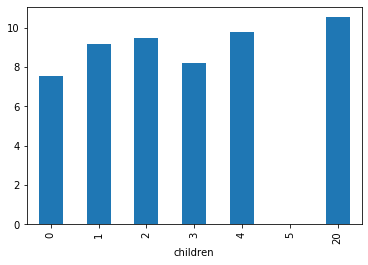

In [7]:
# Смотрим на распределение количества займов по количеству детей
children_count_group = borrowers['children'].value_counts().sort_index()
display(children_count_group)
# Убеждаемся, что ничего не утеряно
display(borrowers['children'].value_counts().sum())

# Группируем по количеству детей и суммируем количество задолженностей
children_sum_group = borrowers.groupby('children')['debt'].sum()
display(children_sum_group)
# Убеждаемся, что ничего не утеряно
display(children_sum_group.sum())

# Находим долю количества просрочек от общего количества займов в группах количества детей
children_percent_debt = (children_sum_group/children_count_group*100).round(2).sort_index()
display(children_percent_debt)

# Создаем финальную таблицу
tmp1 = pd.DataFrame(data=sorted(borrowers['children'].unique().tolist()), columns=['children'])
children_debt_finite = tmp1.assign(children_debt=children_percent_debt.reset_index(drop=True))
display(children_debt_finite)

# Создаем столбчатую диаграмму
children_percent_debt.plot(kind="bar")

### Вывод

### Процент задолженности от количества детей
Ввиду малой выборки для количества детей 5 и явного выпадения из статистического распределения количества детей 20 считаем эти данные нерепрезентативной выборкой.
Процент задолженностей в зависимости от количества детей в диапазоне от 0 до 4 находится в пределах от 7,54 % до 9,76 %. При этом наблюдается тенденция к увеличению процента просрочек с ростом количества детей у заемщика. Среди заемщиков без детей процент задолженностей 7,54 %, у заемщиков с 4 детьми - 9,76 %.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

0    12339
1     4151
2      959
3     1195
4     2810
Name: family_status_id, dtype: int64

21454

family_status_id
0    931
1    388
2     63
3     85
4    274
Name: debt, dtype: int64

1741

family_status_id
0    7.55
1    9.35
2    6.57
3    7.11
4    9.75
dtype: float64

,family_status_id,family_status,fstatus_debt
0,0,женат / замужем,7.55
1,1,гражданский брак,9.35
2,2,вдовец / вдова,6.57
3,3,в разводе,7.11
4,4,не женат / не замужем,9.75


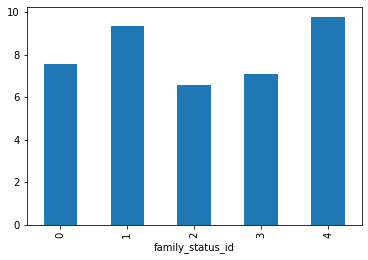

In [8]:
# Смотрим на распределение количества займов по семейному положению
fstatus_count_group = borrowers['family_status_id'].value_counts().sort_index()
display(fstatus_count_group)
# Убеждаемся, что ничего не утеряно
display(borrowers['family_status'].value_counts().sum())

# Группируем по семейному положению и суммируем количество задолженностей
fstatus_sum_group = borrowers.groupby('family_status_id')['debt'].sum()
display(fstatus_sum_group)
# Убеждаемся, что ничего не утеряно
display(fstatus_sum_group.sum())

# Находим долю количества просрочек от общего количества займов в группах семейного положения
fstatus_percent_debt = (fstatus_sum_group/fstatus_count_group*100).round(2).sort_index()
display(fstatus_percent_debt)

# Создаем финальную таблицу 
fstatus_debt_finite = family_status_dict.assign(fstatus_debt=fstatus_percent_debt)
display(fstatus_debt_finite)

# Создаем столбчатую диаграмму
fstatus_percent_debt.plot(kind="bar")

### Вывод

### Процент задолженности от семейного положения
Процент задолженностей в зависимости от семейного положения находится в пределах от 6,57 % до 9,75 %.
Самые надежные заемщики - вдовцы (6,57 %) и разведенные (7,11 %). Самые ненадежные - неженатые (9,75 %) и состоящие в гражданском браке (9,35 %). Количество задолженностей среди вдовцов почти в 1,5 раза меньше, чем среди неженатых. 

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

0     372
1    4091
2    7160
3    7018
4    2813
Name: total_income_id, dtype: int64

21454

total_income_id
0     23
1    331
2    624
3    569
4    194
Name: debt, dtype: int64

1741

total_income_id
0    6.18
1    8.09
2    8.72
3    8.11
4    6.90
dtype: float64

,total_income_id,total_income,income_debt
0,0,< 50,6.18
1,1,50-100,8.09
2,2,100-150,8.72
3,3,150-250,8.11
4,4,> 250,6.90


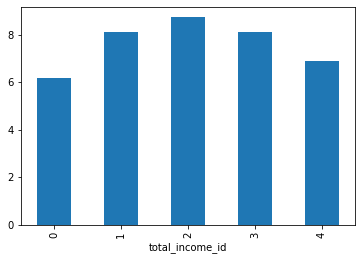

In [9]:
# Смотрим на распределение количества займов по доходу
tincome_count_group = borrowers['total_income_id'].value_counts().sort_index()
display(tincome_count_group)
# Убеждаемся, что ничего не утеряно
display(borrowers['total_income_id'].value_counts().sum())

# Группируем по доходу и суммируем количество задолженностей
tincome_sum_group = borrowers.groupby('total_income_id')['debt'].sum()
display(tincome_sum_group)
# Убеждаемся, что ничего не утеряно
display(tincome_sum_group.sum())

# Находим долю количества просрочек от общего количества займов в группах дохода
income_percent_debt = (tincome_sum_group/tincome_count_group*100).round(2).sort_index()
display(income_percent_debt)

# Создаем финальную таблицу 
income_debt_finite = total_income_dict.assign(income_debt=income_percent_debt)
display(income_debt_finite)

# Создаем столбчатую диаграмму
income_percent_debt.plot(kind="bar")

### Вывод

### Процент задолженности от дохода
Процент задолженностей в зависимости от дохода находится в пределах от 6,18 % до 8,72 %. Максимум задолженностей приходится на среднюю группу с доходом от 100 до 150 тыс. - 8,72 %. Самые надежные заемщики имеют доход < 50 тыс. (6,18 %), на втором месте - заемщики с доходом > 250 тыс. (6,90 %).

- Как разные цели кредита влияют на его возврат в срок?

0    4306
1    9500
2    1311
3    4013
4    2324
Name: purpose_id, dtype: int64

21454

purpose_id
0    403
1    683
2     99
3    370
4    186
Name: debt, dtype: int64

1741

purpose_id
0    9.36
1    7.19
2    7.55
3    9.22
4    8.00
dtype: float64

,purpose_id,purpose,purpose_debt
0,0,автомобиль,9.36
1,1,жилье,7.19
2,2,коммерческая недвижимость,7.55
3,3,образование,9.22
4,4,свадьба,8.00


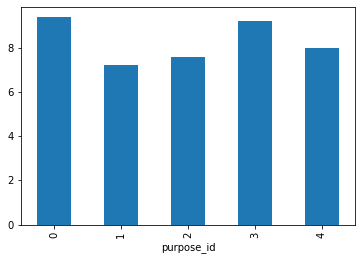

In [10]:
# Смотрим на распределение количества займов по целям
purpose_count_group = borrowers['purpose_id'].value_counts().sort_index()
display(purpose_count_group)
# Убеждаемся, что ничего не утеряно
display(borrowers['purpose_id'].value_counts().sum())

# Группируем по целям и суммируем количество задолженностей
purpose_sum_group = borrowers.groupby('purpose_id')['debt'].sum()
display(purpose_sum_group)
# Убеждаемся, что ничего не утеряно
display(purpose_sum_group.sum())

# Находим долю количества просрочек от общего количества займов в группах целей
purpose_percent_debt = (purpose_sum_group/purpose_count_group*100).round(2).sort_index()
display(purpose_percent_debt)

# Создаем финальную таблицу 
purpose_debt_finite = purpose_dict.assign(purpose_debt=purpose_percent_debt)
display(purpose_debt_finite)

# Создаем столбчатую диаграмму
purpose_percent_debt.plot(kind="bar")

### Вывод

### Процент задолженности от целей кредита
Процент задолженностей в зависимости от цели кредита находится в пределах от 7,19 % до 9,36 %.
Цели кредита "Жилье" и "Коммерческая недвижимость" имеют самый низкий процент задолженностей - 7,19 % и 7,55 % соответственно. Наибольший процент задолженностей среди заемщиков, указывающих цель кредита "Автомобиль" - 9,36 %, и "Образование" - 9,22 % 

### Шаг 4. Общий вывод

### Общие выводы
Средний процент задолженностей по всем заемщикам равен 8,11 %.

Портрет надежного заемщика в разрезе поставленных вопросов: разведенный, без детей, с доходом < 50 тыс., приобретающий жилье.
Самый ненадежный заемщик в разрезе поставленных вопросов: многодетный, состоящий в гражданском браке, с доходом 100-150 тыс., приобретающий автомобиль.

Дополнительно рассмотрены 3 среза данных: "Цель - Доход", "Доход - Образование", "Количество детей - образование".
 
По срезу "Цель - Доход" выделяется большой процент просрочек среди заемщиков с доходом < 50 тыс., покупающих автомобиль (13,51 %) и низкий процент просрочек среди заемщиков с доходом < 50 тыс., получающих образование (2,47 %).
 
По срезу "Доход - Образование" выделяются заемщики с ученой степенью, не имеющие задолженностей (0,0 %), низкий процент задолженностей имеют заемщики с высшим образованием и доходом < 50 тыс. (3,23 %). Высокий процент просрочек среди заемщиков, имеющих неоконченное высшее образование, с доходом > 250 тыс. (14,18 %) и среди заемщиков, имеющих начальное образование, с доходом 100-150 тыс. (14,56 %).
 
По срезу "Количество детей - Образование" выделяется большой процент просрочек среди заемщиков с тремя детьми и неоконченным высшим образованием (25,00 %) и заемщиков с двумя детьми и начальным образованием (24,00 %).